In [1]:
from utils import extract_data_and_folds,prepare_datasets
import pandas as pd

In [3]:
# Paso 1: Extraer datos y folds
metadata_df = pd.read_csv(r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8k.csv')
audio_directory = r'D:\Python_D\DeepLearningAudios\audio'
features, labels, folds = extract_data_and_folds(audio_directory, metadata_df)




In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
importlib.reload(models)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.005,
    "hidden_dim1": 8,
    "hidden_dim2": 8,
    "output_dim": 10,
    "dropout_rate": 0.01,
    "weight_decay": 1e-4,
}




avg_results, train_class, valid_class, results = cross_validate("GRU",config,features,labels,folds,epochs = 20,device = device,verbose=2)
    


Entrenando en GPU: NVIDIA GeForce RTX 3060
{'train_losses': 1.9267877485829366, 'valid_losses': 1.9290989226180884, 'train_accuracies': 0.31143089365076615, 'train_f1_scores': 0.2661209125329975, 'train_recalls': 0.31143089365076615, 'valid_accuracies': 0.30809812565291284, 'valid_f1_scores': 0.25519270237918135, 'valid_recalls': 0.30809812565291284}


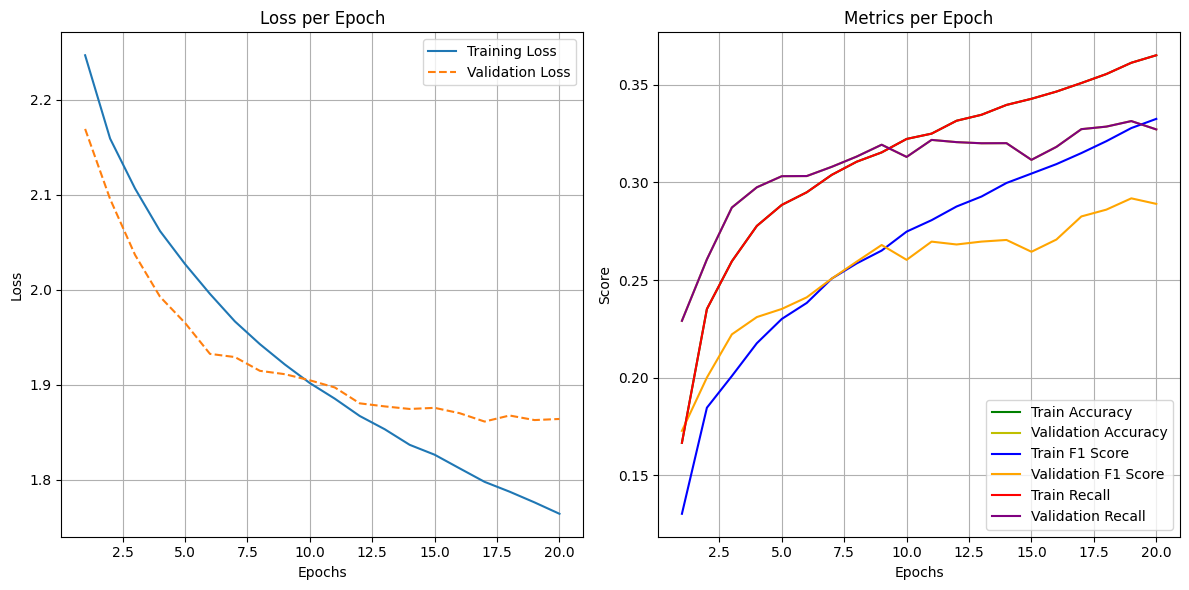

In [37]:
import numpy as np
from visualizations import plot_DL_results

# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


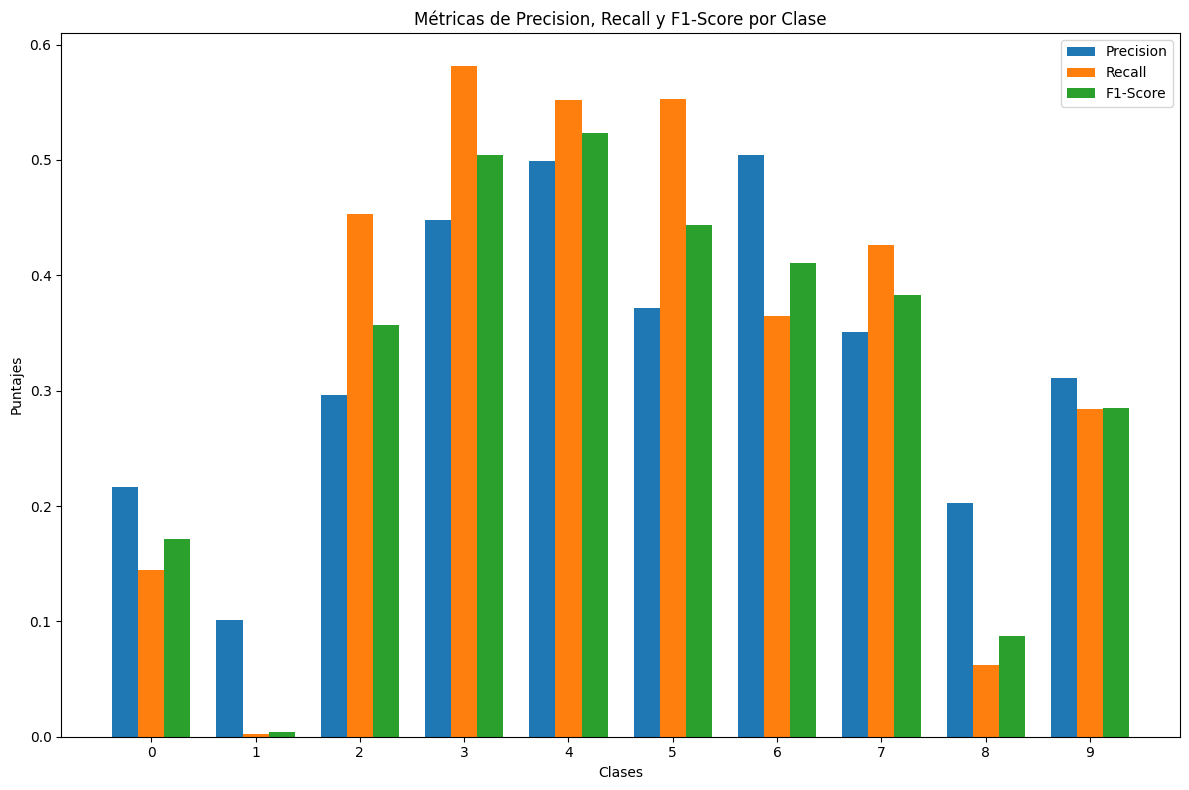

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Inicializa un diccionario para almacenar las medias de cada clase y cada métrica
mean_class_metrics = {}

# Asumiendo que 'results' es una lista de diccionarios con las métricas de cada fold
for fold in results:
    class_metrics = fold['train_class_metrics'][-1]  # Accede a las métricas de la última época
    
    # Itera sobre las clases (0-9)
    for class_id, metrics in class_metrics.items():
        if class_id != 'accuracy' and class_id != 'macro avg' and class_id != 'weighted avg':
            # Si la clase aún no tiene una entrada, inicializa su lista para las métricas
            if class_id not in mean_class_metrics:
                mean_class_metrics[class_id] = {'precision': [], 'recall': [], 'f1-score': []}
            
            # Agrega las métricas actuales a las listas correspondientes
            mean_class_metrics[class_id]['precision'].append(metrics['precision'])
            mean_class_metrics[class_id]['recall'].append(metrics['recall'])
            mean_class_metrics[class_id]['f1-score'].append(metrics['f1-score'])

# Ahora, calcula la media para cada clase
for class_id in mean_class_metrics:
    for metric in ['precision', 'recall', 'f1-score']:
        # Calcula la media de la métrica para esta clase a través de todos los folds
        mean_class_metrics[class_id][metric] = np.mean(mean_class_metrics[class_id][metric])

# Ahora vamos a graficar
# Extraemos los valores para el gráfico
classes = list(mean_class_metrics.keys())
precision_values = [mean_class_metrics[class_id]['precision'] for class_id in classes]
recall_values = [mean_class_metrics[class_id]['recall'] for class_id in classes]
f1_score_values = [mean_class_metrics[class_id]['f1-score'] for class_id in classes]

# Configuramos la posición de las barras
x = np.arange(len(classes))  # El número de clases
width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(x - width, precision_values, width, label='Precision')
bars2 = ax.bar(x, recall_values, width, label='Recall')
bars3 = ax.bar(x + width, f1_score_values, width, label='F1-Score')

# Añadir etiquetas y título
ax.set_xlabel('Clases')
ax.set_ylabel('Puntajes')
ax.set_title('Métricas de Precision, Recall y F1-Score por Clase')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()



In [57]:
metrics = ["precision","recall","f1-score","support"]
mean_metrics = {metric: [] for metric in metrics}

for fold in results : 
    macro_Avg = fold['train_class_metrics'][-1]["macro avg"]
    for key,value in macro_Avg.items() :
        mean_metrics[key] = np.mean(value)

print(mean_metrics)

{'precision': 0.3204980651639731, 'recall': 0.34135328820351685, 'f1-score': 0.31881387873428113, 'support': 7895.0}


In [59]:
metrics = ["precision","recall","f1-score","support"]
mean_metrics = {metric: [] for metric in metrics}

for fold in results : 
    macro_Avg = fold['train_class_metrics'][-1]
    print(macro_Avg)

{'0': {'precision': 0.2646048109965636, 'recall': 0.1711111111111111, 'f1-score': 0.2078272604588394, 'support': 900.0}, '1': {'precision': 0.6, 'recall': 0.007633587786259542, 'f1-score': 0.01507537688442211, 'support': 393.0}, '2': {'precision': 0.319650067294751, 'recall': 0.5277777777777778, 'f1-score': 0.39815590947191953, 'support': 900.0}, '3': {'precision': 0.4762376237623762, 'recall': 0.5344444444444445, 'f1-score': 0.5036649214659686, 'support': 900.0}, '4': {'precision': 0.5209163346613546, 'recall': 0.5811111111111111, 'f1-score': 0.5493697478991597, 'support': 900.0}, '5': {'precision': 0.36431784107946025, 'recall': 0.5376106194690266, 'f1-score': 0.4343163538873995, 'support': 904.0}, '6': {'precision': 0.4859154929577465, 'recall': 0.40707964601769914, 'f1-score': 0.44301765650080255, 'support': 339.0}, '7': {'precision': 0.40096230954290296, 'recall': 0.5681818181818182, 'f1-score': 0.4701457451810061, 'support': 880.0}, '8': {'precision': 0.12631578947368421, 'recall